In [ ]:
# In this notebook I have implemented Resnet-34 Architecture from scratch.
# The dataset used here is the CIFAR-10 dataset which is publicly available.
# The accuracy obtained on the test data is 81.72%

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import os
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
# Using the ResNet-34 architecture 
num_classes = 10
num_epochs = 15
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device) 

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

In [ ]:
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


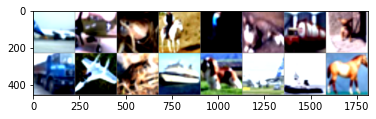

plane plane frog  horse bird  cat   truck dog   truck plane frog  ship  dog   plane ship  horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=15):
    since = time.time()
    
    acc_history = []
    loss_history = []

    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        
        torch.save(model.state_dict(), os.path.join('/content/data', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
train_acc_hist, train_loss_hist = train_model(model, trainloader, criterion, optimizer, device)

Epoch 0/14
----------
Loss: 1.6964 Acc: 0.3762

Epoch 1/14
----------
Loss: 1.0854 Acc: 0.6183

Epoch 2/14
----------
Loss: 0.8121 Acc: 0.7169

Epoch 3/14
----------
Loss: 0.6849 Acc: 0.7653

Epoch 4/14
----------
Loss: 0.6086 Acc: 0.7920

Epoch 5/14
----------
Loss: 0.5544 Acc: 0.8121

Epoch 6/14
----------
Loss: 0.5290 Acc: 0.8183

Epoch 7/14
----------
Loss: 0.4987 Acc: 0.8308

Epoch 8/14
----------
Loss: 0.4698 Acc: 0.8407

Epoch 9/14
----------
Loss: 0.4567 Acc: 0.8458

Epoch 10/14
----------
Loss: 0.4324 Acc: 0.8523

Epoch 11/14
----------
Loss: 0.4176 Acc: 0.8581

Epoch 12/14
----------
Loss: 0.4045 Acc: 0.8615

Epoch 13/14
----------
Loss: 0.3907 Acc: 0.8682

Epoch 14/14
----------
Loss: 0.3793 Acc: 0.8713

Training complete in 76m 6s
Best Acc: 0.871260


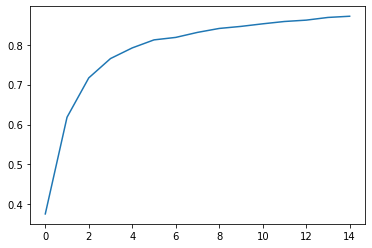

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc_hist)

In [ ]:
def test_model(model, test_loader):
# prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    total=0
    correct=0
    model.eval()
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            total += labels.size(0)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct += 1
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            test_accuracy = 100* correct/total
    print('Test accuracy: {}%'.format(test_accuracy))
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
test_model(model, testloader) 

Test accuracy: 81.72%
Accuracy for class: plane is 94.6 %
Accuracy for class: car   is 87.8 %
Accuracy for class: bird  is 79.4 %
Accuracy for class: cat   is 65.1 %
Accuracy for class: deer  is 68.8 %
Accuracy for class: dog   is 72.9 %
Accuracy for class: frog  is 87.1 %
Accuracy for class: horse is 90.7 %
Accuracy for class: ship  is 80.9 %
Accuracy for class: truck is 89.9 %
